In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [3]:
ad = sc.read_h5ad("08H089_sorted_unsorted_clean_rawcounts.h5")

In [4]:
#make separate object for unsorted cells so we can compare
unsort_ind = [i for i in range(ad.shape[0]) if "sorted" not in ad.obs["sample"][i]]
unsorted = ad[unsort_ind,:]

In [6]:
ad.layers["counts"]=ad.X
sc.pp.calculate_qc_metrics(ad, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# 
ad.obs['original_total_counts'] = ad.obs['total_counts']

# log10 original library size
ad.obs['log10_original_total_counts'] = np.log10(ad.obs['original_total_counts'])

# Normalize by median library size
med = np.median(ad.obs['original_total_counts'])
sc.pp.normalize_per_cell(ad, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(ad)

In [7]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [14]:
sc.pp.calculate_qc_metrics(unsorted, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# 
unsorted.obs['original_total_counts'] = unsorted.obs['total_counts']

# log10 original library size
unsorted.obs['log10_original_total_counts'] = np.log10(unsorted.obs['original_total_counts'])

# Normalize by median library size
med = np.median(unsorted.obs['original_total_counts'])
sc.pp.normalize_per_cell(unsorted, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(unsorted)

/home/lf2684/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
sc.pp.neighbors(unsorted)
sc.tl.umap(unsorted)

In [9]:
new_label = []
for i in unsorted.obs["cell_type"]:
    if i=="lsc" or i=='prelsc':
        new_label.append("immature")
    else:
        new_label.append("other")
palette = {'immature':'red',"other":"grey"}

In [10]:
unsorted.obs["cell type"]=new_label

In [8]:
def compute_mut(adata):
    fast_x = sklearn.decomposition.TruncatedSVD(100).fit_transform(adata.X)
    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
    nn.fit(fast_x)
    neighbors = nn.kneighbors(return_distance=False)

    npm_mut = (adata.obs["NPM1_mut"] == "mut").to_numpy()[neighbors].sum(axis=1)
    npm_wt = (adata.obs["NPM1_wt"] == "wt").to_numpy()[neighbors].sum(axis=1)
    #dnm_mut = (adata.obs["DNMT3A_mut"] == "mut").to_numpy()[neighbors].sum(axis=1)
    #dnm_wt = (adata.obs["DNMT3A_wt"] == "wt").to_numpy()[neighbors].sum(axis=1)

    npm_mut_ratio = npm_mut / (npm_mut + npm_wt + 1e-10)
    #dnm_mut_ratio = dnm_mut / (dnm_mut + dnm_wt + 1e-10)

    adata.obs["NPM1 mutation vs wild type"] = npm_mut_ratio
    #adata.obs["DNMT3A mutation vs wild type"] = dnm_mut_ratio
    return adata

unsorted = compute_mut(unsorted)

Trying to set attribute `.obs` of view, copying.


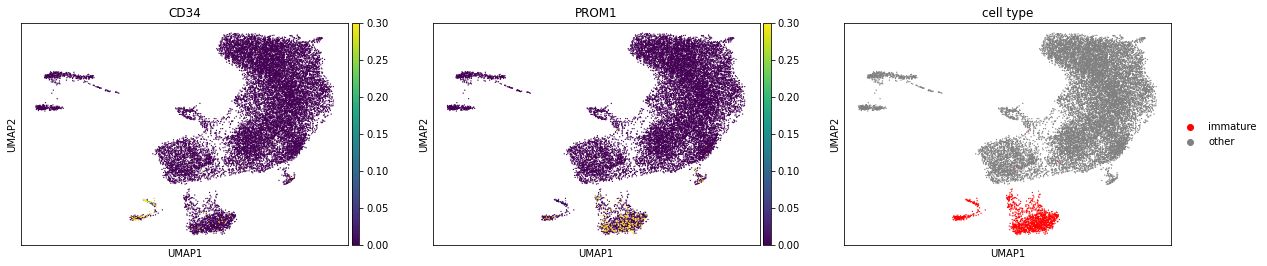

In [71]:
sc.pl.umap(unsorted,color=["CD34","PROM1","cell type"],vmax=.3,palette=palette,save="unsorted_umap.pdf")

In [21]:
sc.tl.rank_genes_groups(unsorted, groupby="cell type", use_raw=True)

In [24]:
df = sc.get.rank_genes_groups_df(unsorted, group="immature")
df.index = df["names"]

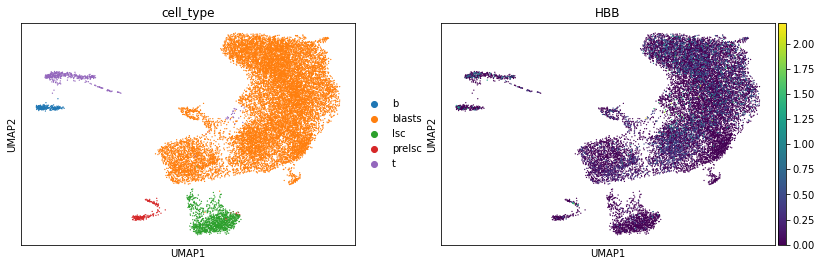

In [16]:
sc.pl.umap(unsorted,color=["cell_type","HBB"])

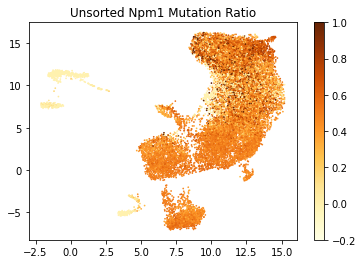

In [16]:
randomize=np.arange(unsorted.shape[0])
np.random.shuffle(randomize)
plt.scatter(unsorted.obsm["X_umap"][:,0][randomize],unsorted.obsm["X_umap"][:,1][randomize],rasterized=True,
                c=unsorted.obs["NPM1 mutation vs wild type"][randomize],vmin=-.2,vmax=1,cmap="YlOrBr",s=.5)
plt.colorbar()
plt.title("Unsorted Npm1 Mutation Ratio")
plt.savefig("figures/unsorted_muts.pdf")


In [10]:
new_label = []
for i in ad.obs["cell_type"]:
    if i=="lsc" or i=='prelsc':
        new_label.append("immature")
    else:
        new_label.append("other")
palette = {'immature':'red',"other":"grey"}

In [11]:
ad.obs["cell type"]=new_label
#sc.pl.umap(ad,color="new",palette=palette)

In [12]:
ad = compute_mut(ad)

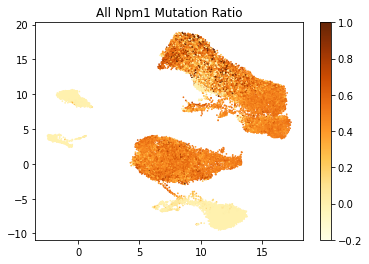

In [13]:
randomize=np.arange(ad.shape[0])
np.random.shuffle(randomize)
plt.scatter(ad.obsm["X_umap"][:,0][randomize],ad.obsm["X_umap"][:,1][randomize],
                c=ad.obs["NPM1 mutation vs wild type"][randomize],rasterized=True,vmin=-.2,vmax=1,cmap="YlOrBr",s=.5)
plt.colorbar()
plt.title("All Npm1 Mutation Ratio")
plt.savefig("figures/all_muts.pdf")


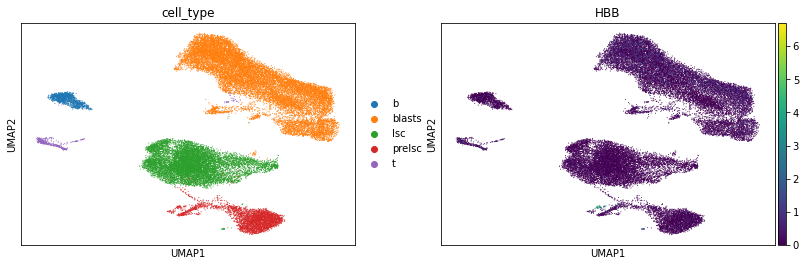

In [19]:
sc.pl.umap(ad,color=["cell_type","HBB"])

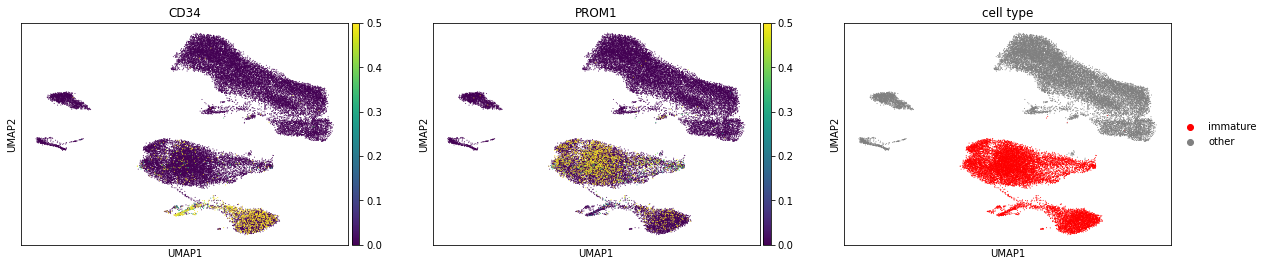

In [73]:
sc.pl.umap(ad,color=["CD34","PROM1","cell type"],vmax=.5,palette=palette,save="allcells_umap.pdf")

/home/lf2684/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


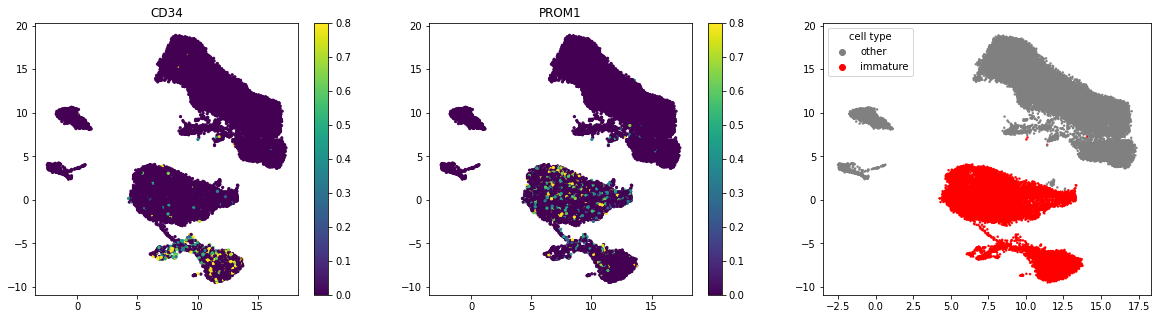

In [40]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
a0 = ax[0].scatter(ad.obsm["X_umap"][:,0],ad.obsm["X_umap"][:,1],c=ad.to_df()["CD34"],s=5,vmax=.8)
ax[0].set_title("CD34")
a1 = ax[1].scatter(ad.obsm["X_umap"][:,0],ad.obsm["X_umap"][:,1],c=ad.to_df()["PROM1"],s=5,vmax=.8)
ax[1].set_title("PROM1")
sns.scatterplot(ad.obsm["X_umap"][:,0],ad.obsm["X_umap"][:,1],hue=ad.obs["cell type"],
                ax=ax[2],palette=palette,s=5,vmax=.8,edgecolor=None)
cbar0 = fig.colorbar(a0,ax=ax[0])
cbar1 = fig.colorbar(a1,ax=ax[1])

In [59]:
sort_status = []
for i in ad.obs["sample"]:
    if "sorted" not in i:
        sort_status.append("unsorted")
    else:
        sort_status.append("sorted")
ad.obs["sort_status"]=sort_status

In [62]:
plot_key = []
for i in range(ad.shape[0]):
    if ad.obs["sort_status"][i]=="sorted" and ad.obs["cell type"][i]=="immature":
        plot_key.append("immature (all cells)")
    elif ad.obs["sort_status"][i]=="sorted" and ad.obs["cell type"][i]=="other":
        plot_key.append("non-immature (all cells)")
    elif ad.obs["sort_status"][i]=="unsorted" and ad.obs["cell type"][i]=="immature":
        plot_key.append("immature (unsorted)")
    elif ad.obs["sort_status"][i]=="unsorted" and ad.obs["cell type"][i]=="other":
        plot_key.append("non-immature (unsorted)")
ad.obs["plot_key"]=plot_key

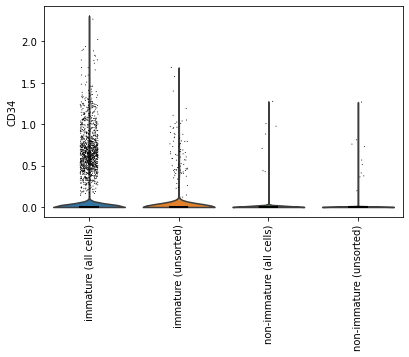

In [69]:
sc.pl.violin(ad, keys='CD34', groupby='plot_key', rotation=90,save="sort_unsort_CD34.pdf")

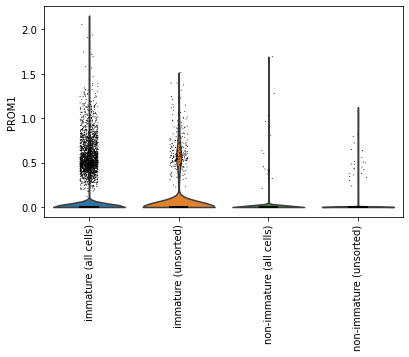

In [68]:
sc.pl.violin(ad, keys='PROM1', groupby='plot_key', rotation=90,save="sort_unsort_PROM1.pdf")

In [19]:
def subsample(adata, select, key):
    #select is the column in adata.obs that we will subsample by
    #key is the entries in obs that we will select
    index=[]
    for i in range(len(adata.obs[select])):
        if adata.obs[select][i] in key:
            index.append(i)
    return adata[index,:]